In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from PIL import Image
import matplotlib.pyplot as plt
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip '/content/drive/MyDrive/MURA-v1.1.zip' -d '/content/'

Streaming output truncated to the last 5000 lines.
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: /content/MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: /content/MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: /content/MURA-v1.1/train/XR_SHOU

### 1. Load Data and Split into Train/Val/Test Sets

In [5]:
def create_data_frame(filepath):
    df = pd.read_csv(filepath, names=['file_path', 'label'])
    df['body_part'] = df.apply(lambda x: x.file_path.split('/')[2][3:],axis=1)
    df['patient_id'] = df.apply(lambda x: x.file_path.split('/')[3][7:],axis=1)
    df['study_type'] = df.apply(lambda x: x.file_path.split('/')[4][:6],axis=1)
    return df

In [6]:
train_file_path = '/content/MURA-v1.1/train_labeled_studies.csv'
test_file_path = '/content/MURA-v1.1/valid_labeled_studies.csv'  # Because we do not have access to testing data, so use Val as Test
train_df = create_data_frame(train_file_path)
test_data = create_data_frame(test_file_path)

In [7]:
# Split training set into train/val - keep patients together
groups = train_df['patient_id']
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(train_df, groups=groups))

train_data = train_df.iloc[train_idx]
val_data = train_df.iloc[val_idx]

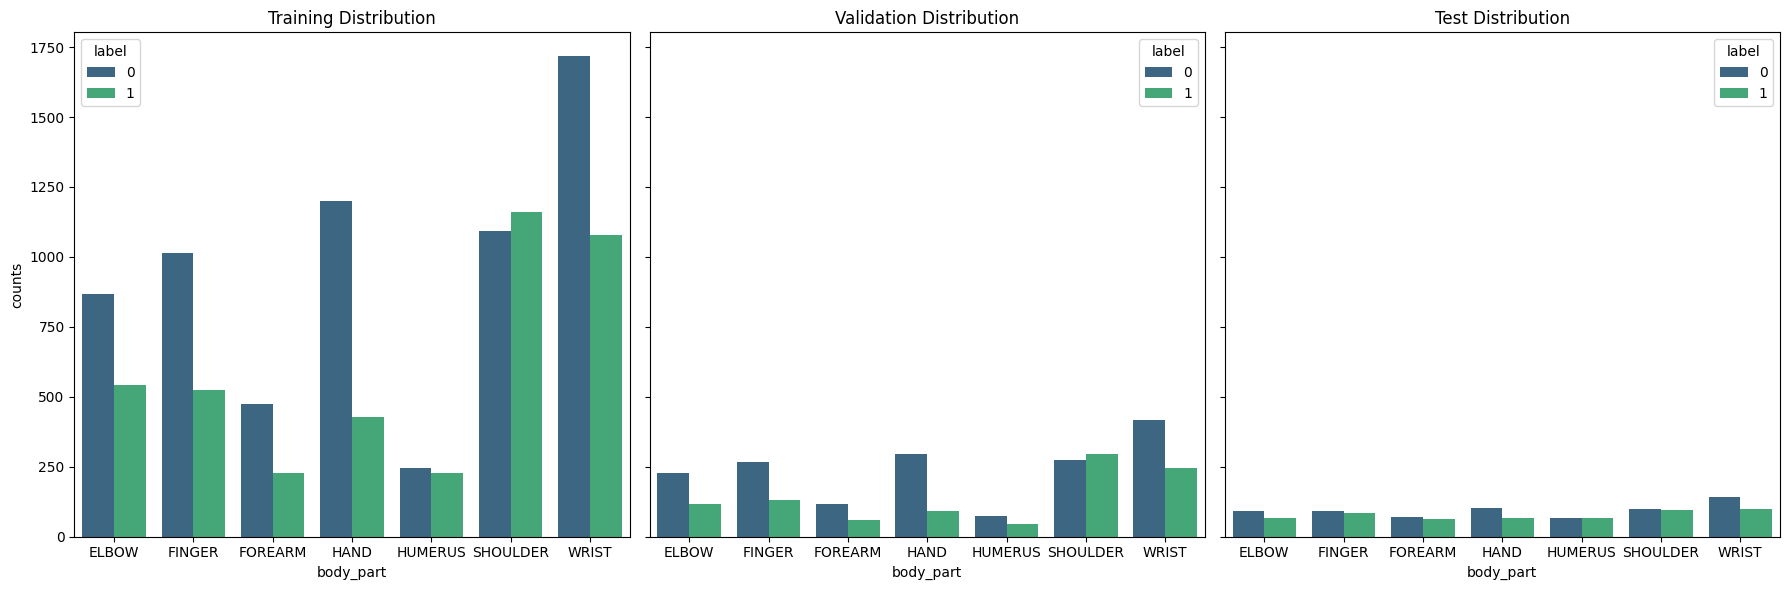

In [16]:
# Distribution of data set by class and label
body_part_label_counts_train = train_data.groupby(['label', 'body_part']).size().reset_index(name='counts')
body_part_label_counts_val = val_data.groupby(['label', 'body_part']).size().reset_index(name='counts')
body_part_label_counts_test = test_data.groupby(['label', 'body_part']).size().reset_index(name='counts')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot for training data
sns.barplot(data=body_part_label_counts_train, x='body_part', y='counts', hue='label', ax=axes[0], palette='viridis')
axes[0].set_title('Training Distribution')

# Plot for validation data
sns.barplot(data=body_part_label_counts_val, x='body_part', y='counts', hue='label', ax=axes[1], palette='viridis')
axes[1].set_title('Validation Distribution')

# Plot for test data
sns.barplot(data=body_part_label_counts_test, x='body_part', y='counts', hue='label', ax=axes[2], palette='viridis')
axes[2].set_title('Test Distribution')

fig.tight_layout()
plt.show()


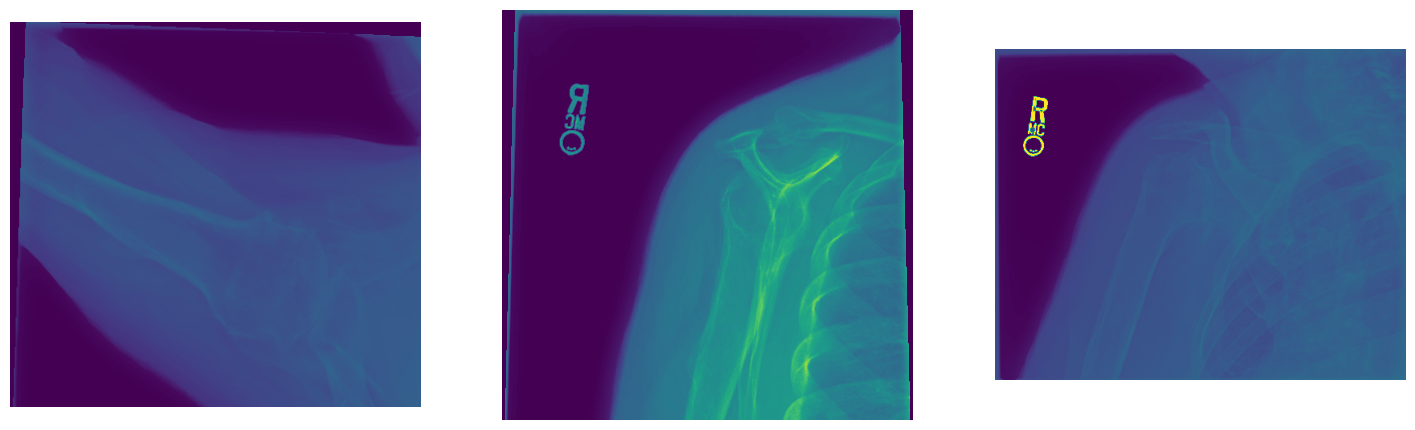

In [17]:
# Example X-ray
image_folder = train_data['file_path'].iloc[0]  # First patient
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder)]

# Plot
fig, axes = plt.subplots(1, len(image_files), figsize=(18, 6), sharey=True)

for i, img_path in enumerate(image_files):
    image = Image.open(img_path)
    axes[i].imshow(image)
    axes[i].axis('off')

plt.show()

### 2. Create Data Set and Data Loaders

In [8]:
from torch.utils.data import Dataset
from torchvision import transforms
import PIL.Image as Image
from torch.utils.data import DataLoader
import torch
from torchvision.datasets.folder import pil_loader
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
import os
import re

In [9]:
class MuraDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Args:
            df (DataFrame): DataFrame containing file paths and labels.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_folder = self.df.iloc[idx]['file_path']
        image_paths = []
        # Prevent .img error
        for file in os.listdir(image_folder):
          if re.match(r'image\d+\.png$', file.lower()):
            image_paths.append(os.path.join(image_folder, file))
        images = [Image.open(image_path).convert('L') for image_path in image_paths]  #Should we do Grayscale 'L' or 'LA' ?

        if self.transform:
            images = [self.transform(image) for image in images]

        label = self.df.iloc[idx]['label']
        #label = torch.from_numpy(np.asarray(label)).double().type(torch.FloatTensor)

        return images, label

# Define transformations
train_transform = transforms.Compose([
        transforms.Resize(224),
         transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])

val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.456], [0.224])
    ])

# Dataset and DataLoader
train_dataset = MuraDataset(df=train_data, transform=train_transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=5, num_workers=0, collate_fn=lambda x: zip(*x), shuffle=True)  # Collate handles diff number of images per study
first_batch = next(iter(train_loader))

In [10]:
val_dataset = MuraDataset(df=val_data, transform=val_transform)
val_loader = DataLoader(dataset=val_dataset, batch_size=5, num_workers=0, collate_fn=lambda x: zip(*x), shuffle=False)

test_dataset = MuraDataset(df=test_data, transform=val_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=5, num_workers=0, collate_fn=lambda x: zip(*x), shuffle=False)


first_batch = next(iter(val_loader))
first_batch = next(iter(test_loader))

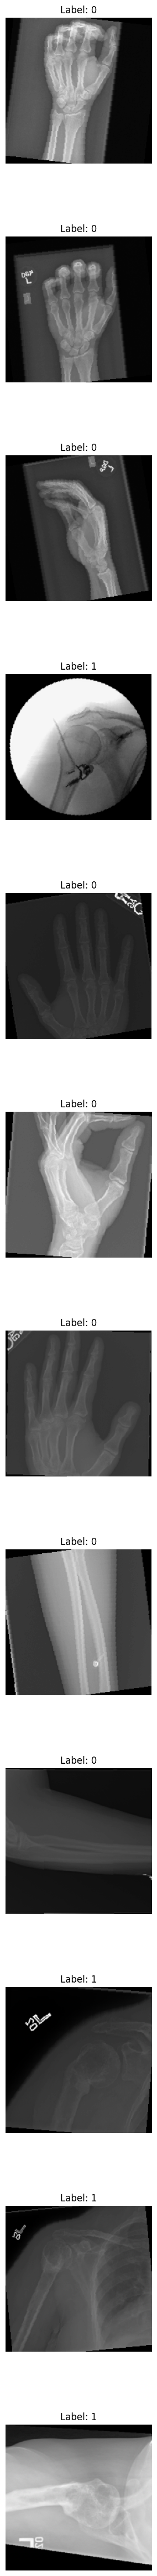

In [11]:
def show_images(batch):
    images, labels = batch
    batch_size = len(images)

    n_rows = sum(len(imgs) for imgs in images)
    if n_rows > 1:
        fig, axes = plt.subplots(n_rows, 1, figsize=(5, n_rows * 5))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(figsize=(5, 5))
        axes = [axes]

    fig.subplots_adjust(hspace=0.5)
    current_row = 0
    for i in range(batch_size):
        for img in images[i]:
            ax = axes[current_row]
            luminance_channel = img[0, :, :]
            ax.imshow(luminance_channel, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Label: {labels[i]}')
            current_row += 1
    plt.show()

first_batch = next(iter(train_loader))
# Uncomment to show images from one batch
show_images(first_batch)


In [12]:
first_batch = next(iter(train_loader))
images, label = first_batch

### 3. Define Model

In [13]:
from torchvision.models import resnet18

class MultiViewCNN(nn.Module):
    def __init__(self):
        super(MultiViewCNN, self).__init__()
        self.base_model = resnet18(weights=None)
        # Change the first conv layer to take 1 channel input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)  # Output a single probability per view

    def forward(self, x):
        batch_probabilities = []
        for views in x:
            view_probabilities = [torch.sigmoid(self.base_model(view.unsqueeze(0))) for view in views]
            view_probabilities = torch.cat(view_probabilities, dim=0)
            study_probability = torch.mean(view_probabilities, dim=0, keepdim=True)
            batch_probabilities.append(study_probability)

        batch_probabilities = torch.cat(batch_probabilities, dim=0)
        return batch_probabilities

In [14]:

class MultiViewCNN2(nn.Module):
    def __init__(self):
        super(MultiViewCNN2, self).__init__()
        self.base_model = resnet18(weights=None)
        # Change the first conv layer to take 1 channel input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=3, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)  # Output a single probability per view

    def forward(self, x):
        batch_probabilities = []
        for views in x:
            view_probabilities = [torch.sigmoid(self.base_model(view.unsqueeze(0))) for view in views]
            view_probabilities = torch.cat(view_probabilities, dim=0)
            study_probability = torch.mean(view_probabilities, dim=0, keepdim=True)
            batch_probabilities.append(study_probability)

        batch_probabilities = torch.cat(batch_probabilities, dim=0)
        return batch_probabilities

In [15]:

class MultiViewCNN3(nn.Module):
    def __init__(self):
        super(MultiViewCNN3, self).__init__()
        self.base_model = resnet18(weights=None)
        # Change the first conv layer to take 1 channel input
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=2, bias=False)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)  # Output a single probability per view

    def forward(self, x):
        batch_probabilities = []
        for views in x:
            view_probabilities = [torch.sigmoid(self.base_model(view.unsqueeze(0))) for view in views]
            view_probabilities = torch.cat(view_probabilities, dim=0)
            study_probability = torch.mean(view_probabilities, dim=0, keepdim=True)
            batch_probabilities.append(study_probability)

        batch_probabilities = torch.cat(batch_probabilities, dim=0)
        return batch_probabilities

### Train Model

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            images, labels = data
            # Move data to device
            labels = torch.tensor(labels).to(device)
            image_batches = [[img.to(device) for img in view] for view in images]

            optimizer.zero_grad()
            outputs = model(image_batches)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(labels)

        train_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in val_loader:
                images, labels = data
                image_batches = [[img.to(device) for img in view] for view in images]
                labels = torch.tensor(labels).to(device)

                outputs = model(image_batches)
                val_loss = criterion(outputs, labels.float().unsqueeze(1))
                running_val_loss += val_loss.item() * len(labels)

                predicted = outputs.round()
                total += labels.size(0)
                correct += (predicted == labels.float().unsqueeze(1)).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    print('Finished Training')


In [22]:
# Train the model
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Train Loss: 0.6796
Epoch 1/1, Validation Loss: 0.6787, Accuracy: 59.80%
Finished Training


In [23]:
# Train the model
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Train Loss: 0.6793
Epoch 1/1, Validation Loss: 0.7355, Accuracy: 58.19%
Finished Training


In [17]:
# Train the model
model = MultiViewCNN()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Train Loss: 38.7445
Epoch 1/1, Validation Loss: 37.1848, Accuracy: 62.82%
Finished Training


In [17]:
model = MultiViewCNN2()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Train Loss: 0.6769
Epoch 1/1, Validation Loss: 1.1189, Accuracy: 60.48%
Finished Training


In [27]:
model = MultiViewCNN3()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

Epoch 1/1, Train Loss: 0.6757
Epoch 1/1, Validation Loss: 0.9187, Accuracy: 63.04%
Finished Training
